# 0. Imports

In [166]:
import scipy

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import kernel_ridge as kr
from sklearn import preprocessing as pp
from sklearn import neural_network as nn
from sklearn import model_selection as ms
from sklearn import gaussian_process as gp
from sklearn import cross_decomposition as cd

from sklearn.feature_selection import SelectKBest, RFE, mutual_info_regression

from statsmodels import api

## 0.1. Functions

In [2]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    #display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):

    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = scipy.stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def ml_metrics(y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return mae, mape, rmse

def cross_validation(models_performance_cv, num_folds, model_name, model, mm_production, x_train, y_train):

    kfold = ms.KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):

        # separate train folds and val fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()

        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        # train model
        model_fit = model.fit(x_train_fold, y_train_fold)

        # predict values with trained model
        yhat_model = model_fit.predict(x_val_fold)
    
        #performance
        m_result = ml_error(model_name, mm_production.inverse_transform([y_val_fold]), mm_production.inverse_transform([yhat_model]))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        print(f"{model_name} Fold {i} Finished")

        i+=1

    model_performance = pd.DataFrame({'Model Name': model_name,
                                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

    models_performance_cv = pd.concat([models_performance_cv, model_performance])
        
    return models_performance_cv

# 1. Data Exploration

In [168]:
df1 = pd.read_csv('dados_resultados.csv')

In [169]:
vo2_column = df1['VO2']
df1 = df1.drop(['VO2'], axis=1)
df1.insert(len(df1.columns), 'VO2', vo2_column)

In [170]:
df1.head()

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2
0,1,-130.8400,0.6720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.2857,15,53.7000,161,NaN,NaN,NaN,5.6240
1,1,-130.1680,0.6720,0.6720,0.0000,0.0000,89.2857,0.0000,0.0000,0.0000,0.0000,89.2857,15,53.7000,161,0.0000,0.0000,0.0000,5.6240
2,1,-129.5360,0.6320,0.6587,0.0231,0.0283,91.0931,1.0000,0.0000,50.0000,0.0000,94.9367,15,53.7000,161,0.0000,0.0000,0.0000,5.6115
3,1,-128.8240,0.7120,0.6720,0.0327,0.0516,89.2857,2.0000,1.0000,66.6667,33.3333,84.2697,15,53.7000,161,0.0000,0.0000,0.0000,5.6115
4,1,-127.9480,0.8760,0.7128,0.0955,0.0934,84.1751,3.0000,2.0000,75.0000,50.0000,68.4932,15,53.7000,161,0.0000,0.0000,0.0000,5.6115


In [171]:
df1.columns

Index(['TestID', 'Time', 'RR', 'mean_RR', 'std_RR', 'rmssd', 'HR_mean', 'NN20',
       'NN50', 'pNN20', 'pNN50', 'FC', 'Idade', 'Peso', 'Altura', 'VLF', 'LF',
       'HF', 'VO2'],
      dtype='object')

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 50914
Number of Cols: 19


## 1.1. NA Values

In [8]:
df1.isna().sum()

TestID      0
Time        0
RR          0
mean_RR    18
std_RR     18
rmssd      18
HR_mean    18
NN20       18
NN50       18
pNN20      18
pNN50      18
FC          0
Idade       0
Peso        0
Altura      0
VLF        18
LF         18
HF         18
VO2         0
dtype: int64

In [9]:
df1 = df1.dropna()

## 1.2. Data Types

In [10]:
df1.dtypes

TestID       int64
Time       float64
RR         float64
mean_RR    float64
std_RR     float64
rmssd      float64
HR_mean    float64
NN20       float64
NN50       float64
pNN20      float64
pNN50      float64
FC         float64
Idade        int64
Peso       float64
Altura       int64
VLF        float64
LF         float64
HF         float64
VO2        float64
dtype: object

## 1.3. Features Metrics

In [11]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [12]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,TestID,1.0000,18.0000,17.0000,9.4340,10.0000,5.0494,0.0018,-1.2055
1,Time,-219.1440,1504.0560,1723.2000,540.4197,530.0700,386.1224,0.1855,-0.7093
2,RR,0.2520,30.5000,30.2480,0.4435,0.4120,0.2125,74.6056,9257.0596
3,mean_RR,0.4066,1.1160,0.7094,0.5439,0.5089,0.1107,1.2488,1.0552
4,std_RR,0.0000,1.7274,1.7274,0.1781,0.1378,0.1757,4.5032,23.4341
5,rmssd,0.0000,2.4526,2.4526,0.1263,0.0398,0.2756,4.3294,21.0646
6,HR_mean,53.7634,147.5646,93.8012,114.2419,117.9100,19.7599,-0.5459,-0.6001
7,NN20,0.0000,303.0000,303.0000,190.5759,195.5000,45.7752,-1.3073,3.3427
8,NN50,0.0000,173.0000,173.0000,93.5732,100.0000,36.3991,-0.0820,-0.4383
9,pNN20,0.0000,100.0000,100.0000,22.9538,14.4277,20.4387,1.6886,1.9558


In [13]:
df1.sort_values('RR', ascending=False).head(10)

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2
43826,16,75.8200,30.5000,0.8099,1.7274,1.7326,74.0839,174.0000,61.0000,58.5859,20.5387,1.9672,16,70.4000,182,0.0000,0.0000,0.0000,17.6674
17700,6,1028.8720,16.8720,0.4731,0.3554,0.3246,126.8331,230.0000,117.0000,8.9634,4.5596,3.5562,17,65.6000,169,0.0000,0.0000,0.1465,12.4816
21535,8,581.2520,16.7120,0.5055,0.4534,0.4251,118.6894,237.0000,167.0000,15.6850,11.0523,3.5902,15,51.2000,165,0.0000,0.0000,0.0000,34.4335
38168,14,-37.8080,6.5480,0.8906,0.4970,0.5129,67.3733,112.0000,72.0000,81.1594,52.1739,9.1631,13,62.3000,171,0.0000,0.0000,0.0000,9.3767
11920,5,80.9480,5.3080,0.6879,0.2829,0.2559,87.2186,175.0000,98.0000,46.0526,25.7895,11.3037,17,76.4000,186,0.0000,0.0000,0.0000,15.4620
40947,15,-93.8240,1.2440,0.8327,0.1359,0.1158,72.0555,82.0000,50.0000,75.2294,45.8716,48.2315,13,63.5000,172,0.0000,0.0000,0.0000,5.9107
40931,15,-108.7320,1.2280,0.8158,0.1186,0.0931,73.5448,66.0000,36.0000,70.9677,38.7097,48.8599,13,63.5000,172,0.0000,0.0000,0.0000,10.5157
40941,15,-99.4440,1.2040,0.8267,0.1292,0.1059,72.5784,76.0000,45.0000,73.7864,43.6893,49.8339,13,63.5000,172,0.0000,0.0000,0.0000,7.7520
20071,8,-139.3360,1.1720,0.9117,0.1147,0.1299,65.8135,44.0000,35.0000,93.6170,74.4681,51.1945,15,51.2000,165,0.0000,0.0000,0.0000,4.1552
38109,14,-96.3880,1.1680,0.8151,0.1131,0.1163,73.6106,62.0000,35.0000,78.4810,44.3038,51.3699,13,62.3000,171,0.0000,0.0000,0.0000,4.9832


In [14]:
df1[['TestID']].value_counts()

TestID
4         3693
12        3647
13        3636
5         3593
3         3442
11        3141
16        2839
9         2822
14        2807
15        2690
6         2682
10        2634
18        2570
1         2402
7         2206
8         2120
2         1999
17        1973
Name: count, dtype: int64

## 1.4. Graphical Visualizations

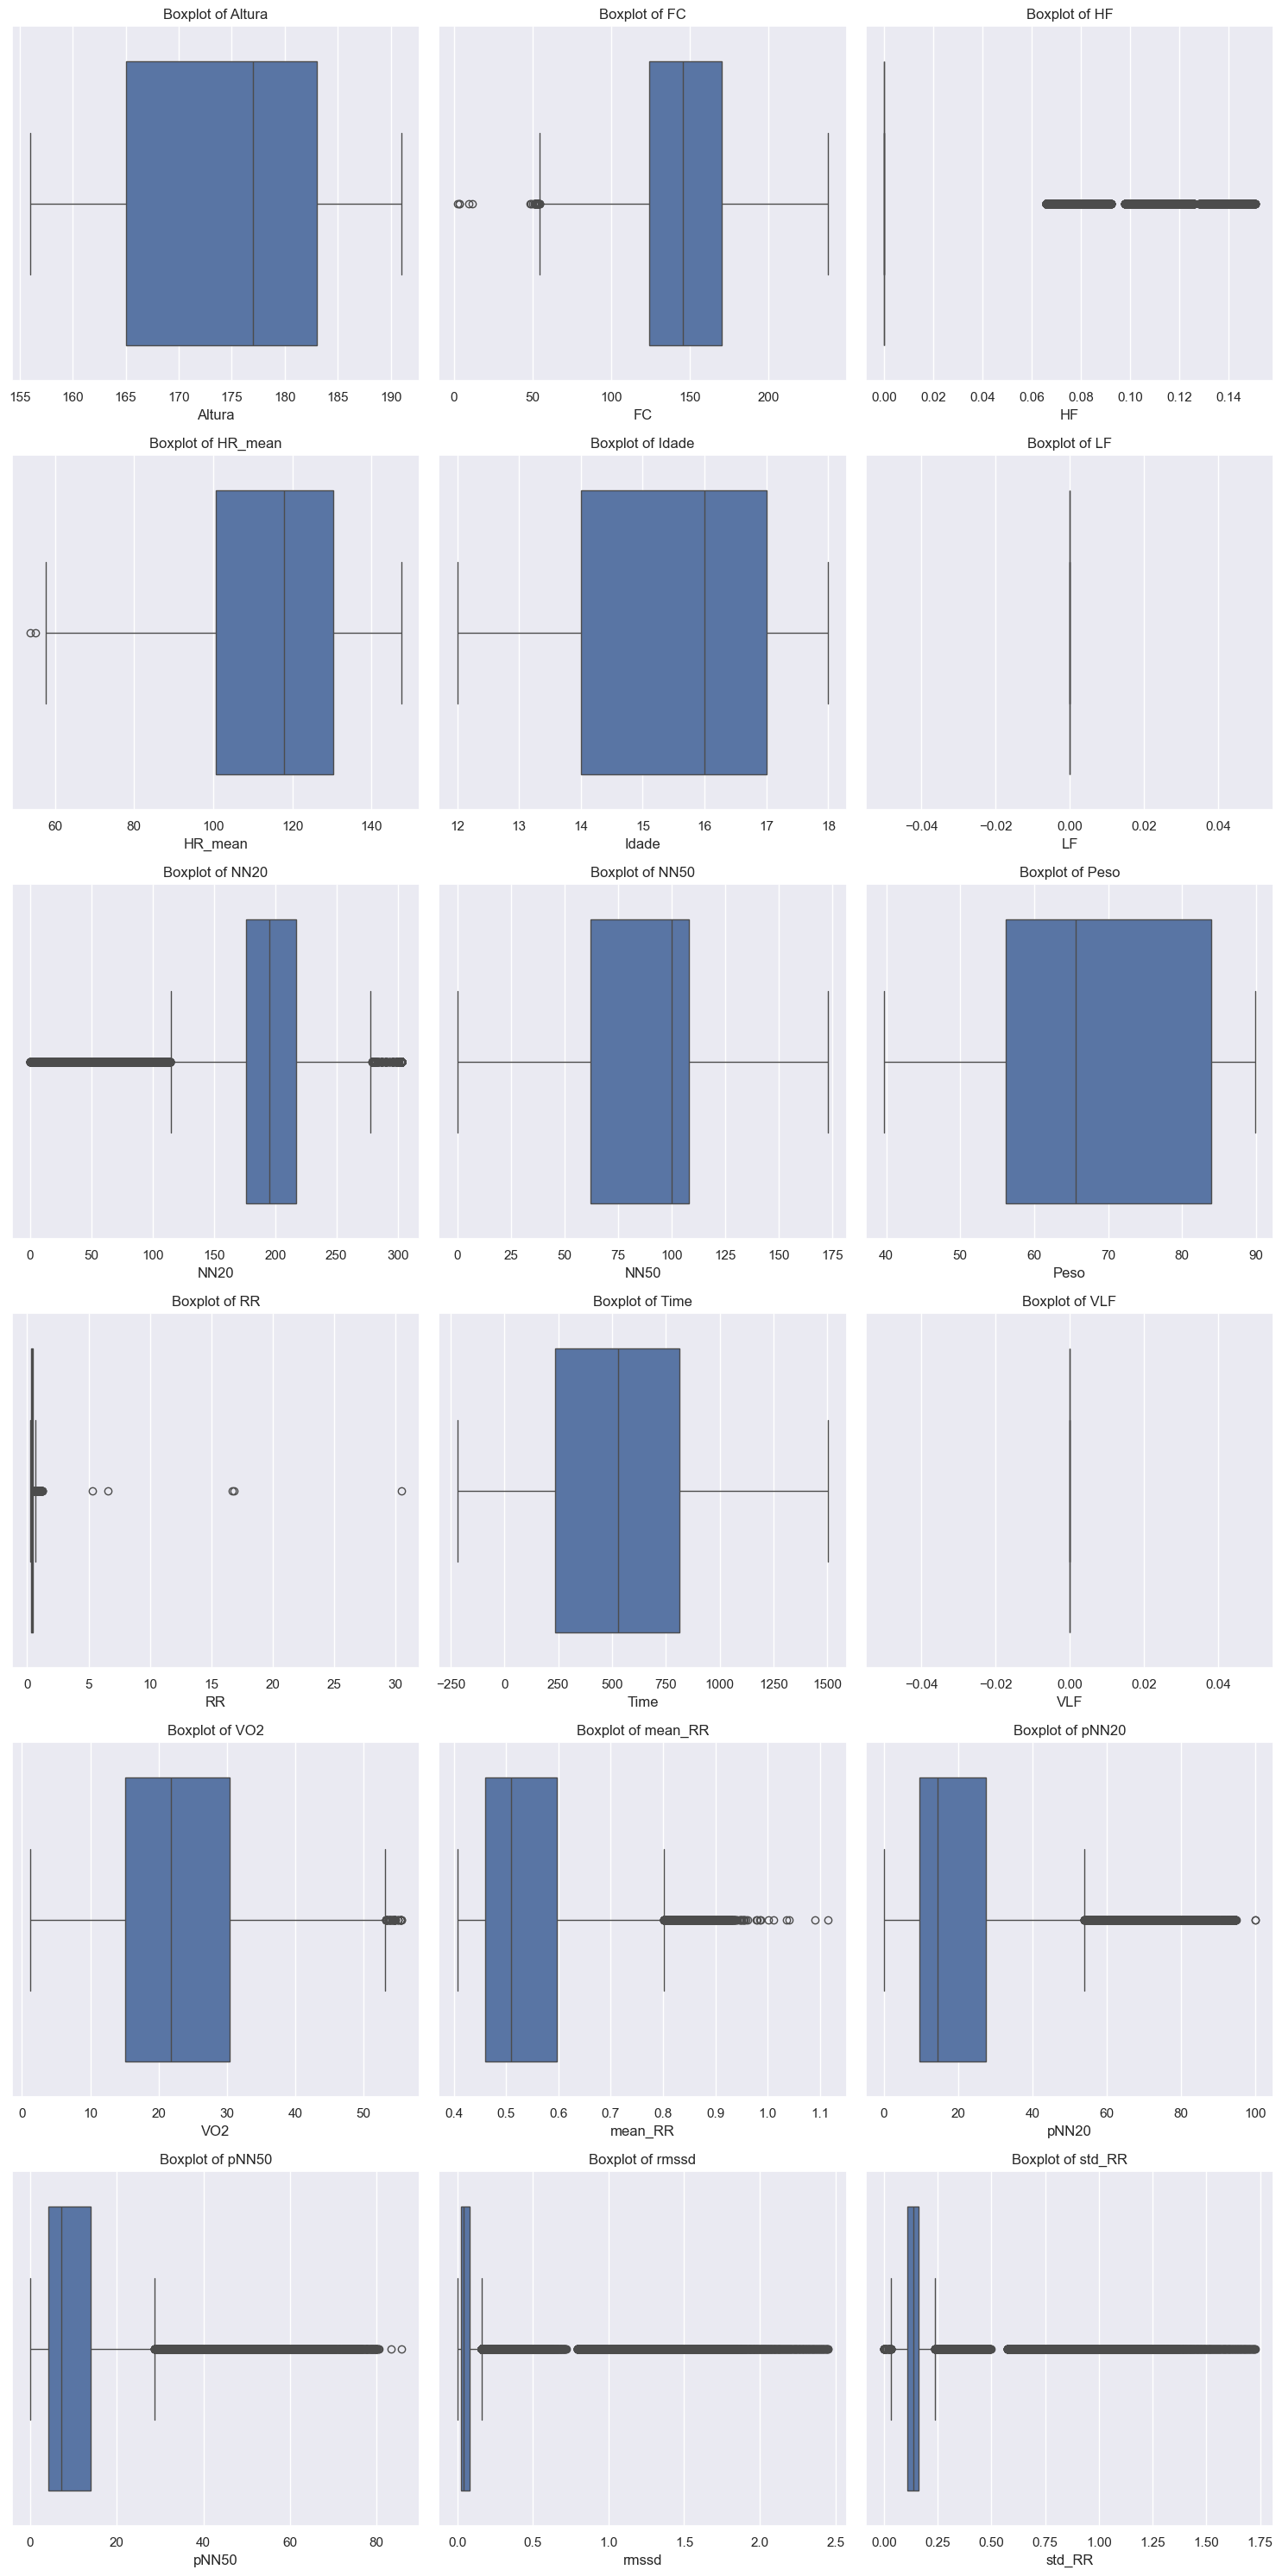

In [15]:
columns_to_plot = df1.columns.difference(['TestID'])
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3 > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

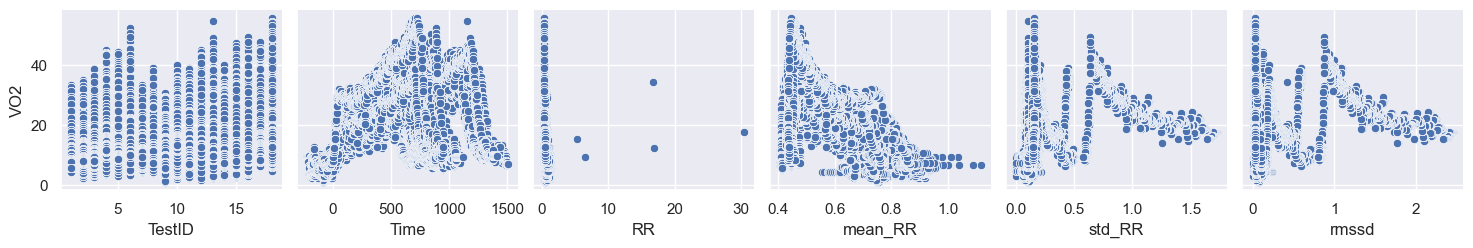

In [16]:
sns.pairplot(df1, y_vars='VO2', x_vars=['TestID', 'Time', 'RR', 'mean_RR', 'std_RR', 'rmssd']);

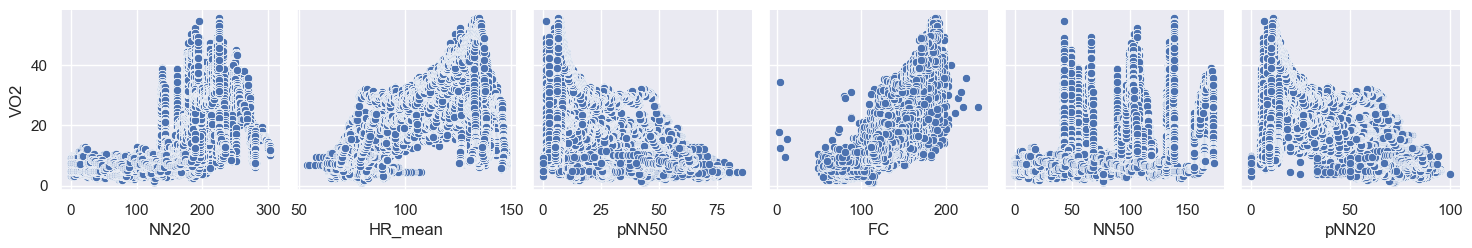

In [17]:
sns.pairplot(df1, y_vars='VO2', x_vars={'HR_mean', 'NN20', 'NN50', 'pNN20', 'pNN50', 'FC'});

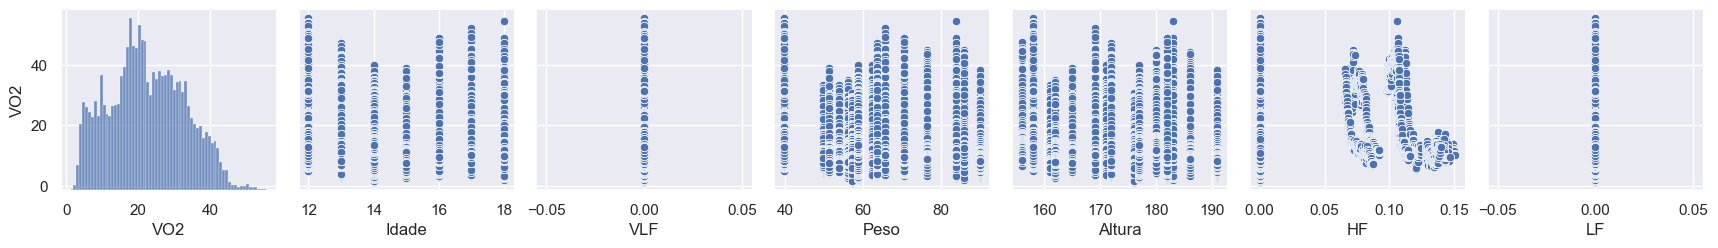

In [18]:
sns.pairplot(df1, y_vars='VO2', x_vars={'Idade', 'Peso', 'Altura', 'VLF', 'LF', 'HF', 'VO2'});

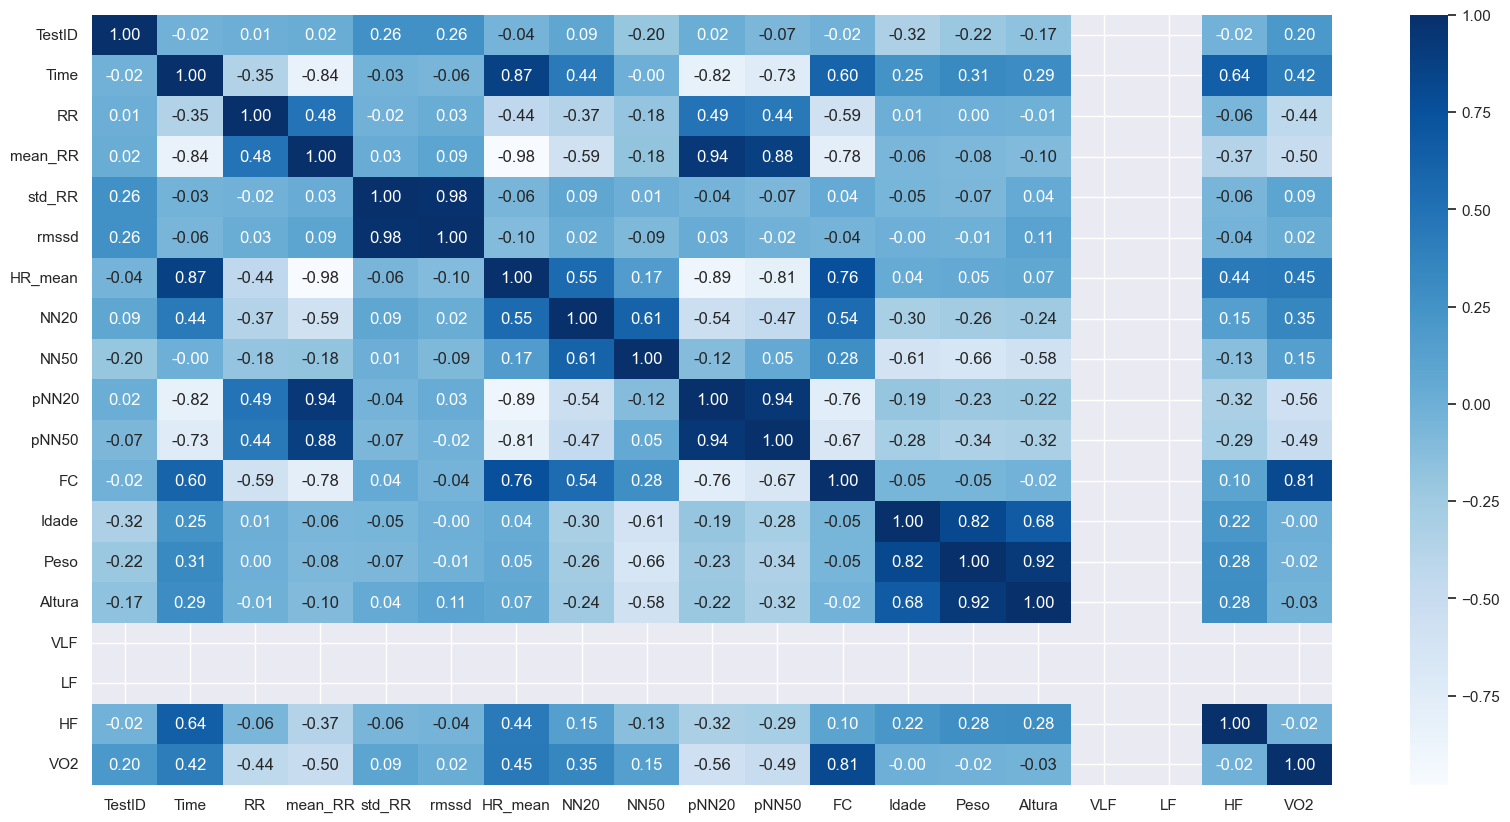

In [19]:

correlation = df1.corr(method='pearson');
sns.heatmap(correlation, cmap="Blues", annot=True, fmt='.2f');

# 2. Dataset Split and Feature Selection

In [20]:
df2 = df1.copy()

In [21]:
x = df2.drop(['VO2'], axis=1).copy()
y = df2['VO2'].copy()

In [22]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.20)

df2_train = pd.concat([x_train, y_train], axis=1)
df2_test = pd.concat([x_test, y_test], axis=1)

In [23]:
mms_TestID = pp.MinMaxScaler()
mms_Time = pp.MinMaxScaler()
mms_FC = pp.MinMaxScaler()
mms_Idade = pp.MinMaxScaler()
mms_Peso = pp.MinMaxScaler()
mms_Altura = pp.MinMaxScaler()
mms_RR = pp.MinMaxScaler()
mms_mean_RR = pp.MinMaxScaler()
mms_std_RR = pp.MinMaxScaler()
mms_rmssd = pp.MinMaxScaler()
mms_HR_mean = pp.MinMaxScaler()
mms_NN20 = pp.MinMaxScaler()
mms_NN50 = pp.MinMaxScaler()
mms_pNN20 = pp.MinMaxScaler()
mms_pNN50 = pp.MinMaxScaler()

df2_train['TestID'] = mms_TestID.fit_transform(df2_train[['TestID']].values)
df2_train['Time'] = mms_Time.fit_transform(df2_train[['Time']].values)
df2_train['FC'] = mms_FC.fit_transform(df2_train[['FC']].values)
df2_train['Idade'] = mms_Idade.fit_transform(df2_train[['Idade']].values)
df2_train['Peso'] = mms_Peso.fit_transform(df2_train[['Peso']].values)
df2_train['Altura'] = mms_Altura.fit_transform(df2_train[['Altura']].values)
df2_train['RR'] = mms_RR.fit_transform(df2_train[['RR']].values)
df2_train['mean_RR'] = mms_mean_RR.fit_transform(df2_train[['mean_RR']].values)
df2_train['std_RR'] = mms_std_RR.fit_transform(df2_train[['std_RR']].values)
df2_train['rmssd'] = mms_rmssd.fit_transform(df2_train[['rmssd']].values)
df2_train['HR_mean'] = mms_HR_mean.fit_transform(df2_train[['HR_mean']].values)
df2_train['NN20'] = mms_NN20.fit_transform(df2_train[['NN20']].values)
df2_train['NN50'] = mms_NN50.fit_transform(df2_train[['NN50']].values)
df2_train['pNN20'] = mms_pNN20.fit_transform(df2_train[['pNN20']].values)
df2_train['pNN50'] = mms_pNN50.fit_transform(df2_train[['pNN50']].values)

mms_VO2 = pp.MinMaxScaler()
df2_train['VO2'] = mms_VO2.fit_transform(df2_train[['VO2']].values)

In [24]:
df2_test['TestID'] = mms_TestID.transform(df2_test[['TestID']].values)
df2_test['Time'] = mms_Time.transform(df2_test[['Time']].values)
df2_test['FC'] = mms_FC.transform(df2_test[['FC']].values)
df2_test['Idade'] = mms_Idade.transform(df2_test[['Idade']].values)
df2_test['Peso'] = mms_Peso.transform(df2_test[['Peso']].values)
df2_test['Altura'] = mms_Altura.transform(df2_test[['Altura']].values)
df2_test['RR'] = mms_RR.transform(df2_test[['RR']].values)
df2_test['mean_RR'] = mms_mean_RR.transform(df2_test[['mean_RR']].values)
df2_test['std_RR'] = mms_std_RR.transform(df2_test[['std_RR']].values)
df2_test['rmssd'] = mms_rmssd.transform(df2_test[['rmssd']].values)
df2_test['HR_mean'] = mms_HR_mean.transform(df2_test[['HR_mean']].values)
df2_test['NN20'] = mms_NN20.transform(df2_test[['NN20']].values)
df2_test['NN50'] = mms_NN50.transform(df2_test[['NN50']].values)
df2_test['pNN20'] = mms_pNN20.transform(df2_test[['pNN20']].values)
df2_test['pNN50'] = mms_pNN50.transform(df2_test[['pNN50']].values)

df2_test['VO2'] = mms_VO2.transform(df2_test[['VO2']].values)

In [25]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [26]:
x_train = df3_train.drop(['VO2'], axis=1)
y_train = df3_train['VO2'].values.ravel()

x_test = df3_test.drop(['VO2'], axis=1)
y_test = df3_test['VO2'].values.ravel()

## 2.1. Features Importance

In [27]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [28]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Features Ranking:")
df = pd.DataFrame()
for i, j, k in zip(x_train, rf.feature_importances_, range(len(rf.feature_importances_))):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[k])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

columns_selected_tree_importance = ['FC', 'Time', 'TestID', 'Peso', 'Idade', 'Altura']


Features Ranking:
    feature  importance
11       FC      0.4030
2        RR      0.2097
1      Time      0.0856
0    TestID      0.0596
6   HR_mean      0.0510
3   mean_RR      0.0461
7      NN20      0.0330
4    std_RR      0.0296
12    Idade      0.0236
13     Peso      0.0186
5     rmssd      0.0095
9     pNN20      0.0093
10    pNN50      0.0086
8      NN50      0.0064
14   Altura      0.0052
17       HF      0.0013
15      VLF      0.0000
16       LF      0.0000


## 2.2. Filter Based Feature Selection

In [97]:
rmse_list = []

for k in range(1, 18):
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(x_train, y_train)
    x_train_selected = selector.transform(x_train)
    x_test_selected = selector.transform(x_test)
    
    rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train_selected, y_train)
    yhat_rf = rf.predict(x_test_selected)
    mae, mape, rmse = ml_metrics(mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))

    rmse_list.append([k, mae, mape, rmse])

df = pd.DataFrame(rmse_list, columns=['k', 'MAE', 'MAPE', 'RMSE'])
df

,k,MAE,MAPE,RMSE
0,1,7.8700,0.5503,10.7452
1,2,0.5724,0.0434,1.3147
2,3,0.4172,0.0305,0.8147
3,4,0.3718,0.0234,0.6916
4,5,0.3790,0.0239,0.7088
5,6,0.3702,0.0227,0.6788
6,7,0.3692,0.0226,0.6766
7,8,0.3655,0.0219,0.6661
8,9,0.3639,0.0218,0.6582
9,10,0.3574,0.0206,0.6482


## 2.3. Wrapper Based Feature Selection

In [145]:
rfr = en.RandomForestRegressor(random_state=42, n_jobs=-1)

rfe = RFE(rfr, n_features_to_select=8, verbose=1)
rfe.fit(x_train, y_train)
selected_features_rfe = rfe.support_

selected_features_list = [feature_name for feature_name, selected in zip(x_train.columns, selected_features_rfe) if selected]
unselected_features_list = [feature_name for feature_name, selected in zip(x_train.columns, selected_features_rfe) if not selected]

print(f'Features selected by RFE: {selected_features_list}')
print(f'Features not selected by RFE: {unselected_features_list}')

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Features selected by RFE: ['TestID', 'Time', 'RR', 'mean_RR', 'std_RR', 'HR_mean', 'FC', 'Idade']
Features not selected by RFE: ['rmssd', 'NN20', 'NN50', 'pNN20', 'pNN50', 'Peso', 'Altura', 'VLF', 'LF', 'HF']


In [149]:
metrics_list = []

for k in range(1, 18):
    RFE_selector = RFE(rfr, n_features_to_select=k, verbose=0, step=1)
    RFE_selector.fit(x_train, y_train)
    x_train_selected = RFE_selector.transform(x_train)
    x_test_selected = RFE_selector.transform(x_test)
    
    rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train_selected, y_train)
    yhat_rf = rf.predict(x_test_selected)
    mae, mape, rmse = ml_metrics(mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))

    rmse_list.append([k, mae, mape, rmse])

df = pd.DataFrame(rmse_list, columns=['k', 'MAE', 'MAPE', 'RMSE'])
df

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fi

,k,MAE,MAPE,RMSE
0,1,7.8700,0.5503,10.7452
1,2,0.5724,0.0434,1.3147
2,3,0.4172,0.0305,0.8147
3,4,0.3718,0.0234,0.6916
4,5,0.3790,0.0239,0.7088
5,6,0.3702,0.0227,0.6788
6,7,0.3692,0.0226,0.6766
7,8,0.3655,0.0219,0.6661
8,9,0.3639,0.0218,0.6582
9,10,0.3574,0.0206,0.6482


## 2.4. Features Variance

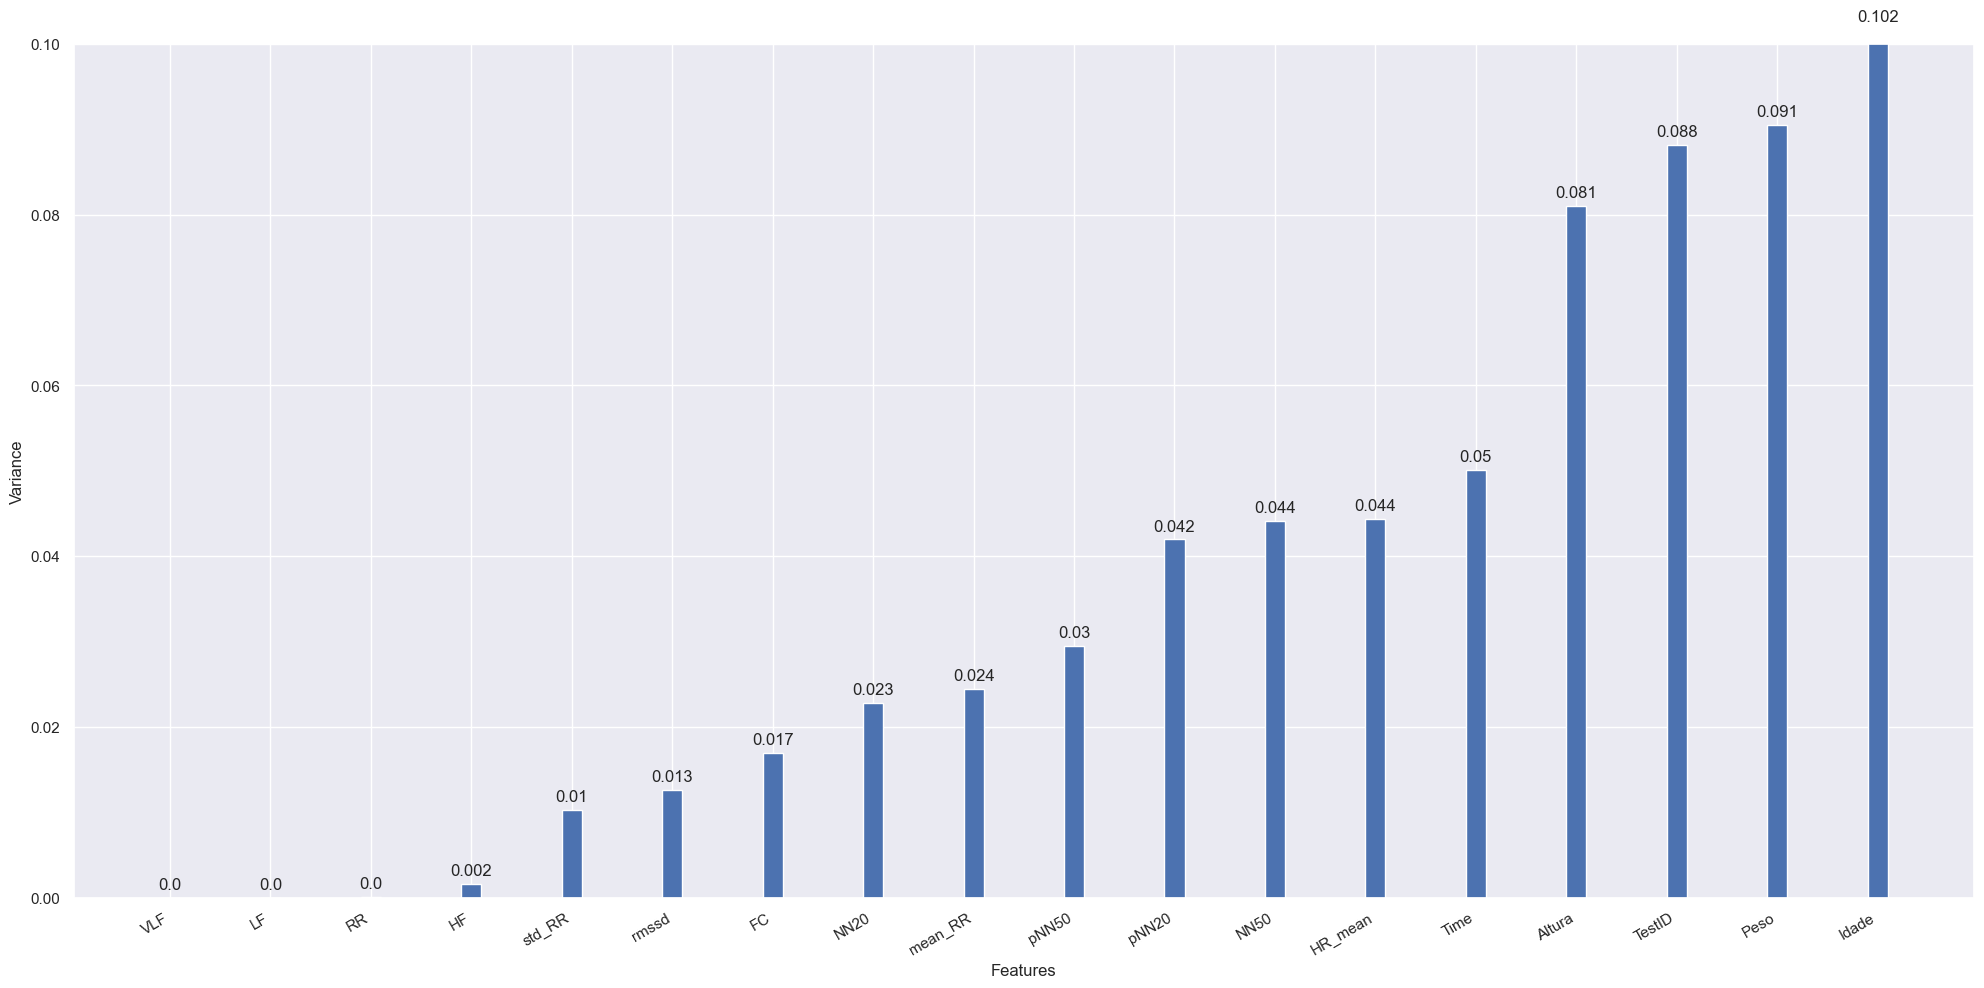

In [122]:
fig, ax = plt.subplots()

x = pd.Series(x_train.columns)
y = x_train.var(axis=0)

sorted_indices = y.argsort()
sorted_x = x.iloc[sorted_indices]
sorted_y = y.iloc[sorted_indices]

ax.bar(sorted_x, sorted_y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(sorted_y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

# 3. Testing Different Sets of Features

In [143]:
drop_list = []
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(selected_features_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(selected_features_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3632,0.0213,0.6779


In [132]:
drop_list = []
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4142,0.0231,0.7437


In [131]:
drop_list = ['VLF']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4142,0.0231,0.7452


In [130]:
drop_list = ['VLF', 'LF']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4138,0.0231,0.7419


In [129]:
drop_list = ['VLF', 'LF', 'RR']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4118,0.0230,0.7415


In [128]:
drop_list = ['VLF', 'LF', 'RR', 'HF']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4120,0.0230,0.7421


In [127]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4115,0.0230,0.7406


In [126]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4166,0.0233,0.7397


In [125]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3557,0.0202,0.6461


In [124]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3557,0.0202,0.6461


In [133]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'mean_RR']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3573,0.0204,0.6481


In [134]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'pNN50']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3569,0.0202,0.6508


In [135]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'pNN20']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3499,0.0199,0.6449


In [164]:
drop_list = ['VLF', 'LF', 'HF', 'rmssd', 'NN20', 'NN50', 'pNN20', 'RR', 'FC', 'std_RR']
x_train.drop(drop_list, axis=1).head()

,TestID,Time,mean_RR,HR_mean,pNN50,Idade,Peso,Altura
41988,0.8235,0.3865,0.2019,0.5902,0.1068,0.1667,0.4741,0.4571
31913,0.6471,0.4027,0.2215,0.5615,0.0446,1.0000,0.9223,0.7714
48292,0.9412,0.6232,0.0703,0.8282,0.0865,0.0000,0.0040,0.0000
39661,0.7647,0.5059,0.1304,0.7084,0.0784,0.1667,0.4502,0.4286
42094,0.8235,0.4104,0.1826,0.6199,0.0978,0.1667,0.4741,0.4571


In [146]:
drop_list = ['VLF', 'LF', 'HF', 'rmssd', 'NN20', 'NN50', 'pNN20', 'RR', 'FC', 'std_RR']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3500,0.0201,0.6427


In [137]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'pNN20', 'NN50', 'HR_mean']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.3507,0.0201,0.6434


In [139]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'pNN20', 'NN50', 'HR_mean', 'Time']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4098,0.0305,0.8474


In [140]:
drop_list = ['VLF', 'LF', 'RR', 'HF', 'std_RR', 'rmssd', 'FC', 'NN20', 'pNN20', 'NN50', 'HR_mean', 'Time', 'Altura']
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train.drop(drop_list, axis=1), y_train)
yhat_rf = rf.predict(x_test.drop(drop_list, axis=1))
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4089,0.0303,0.8215


# 4. Testing Different Models

In [29]:
lr = lm.LinearRegression().fit(x_train, y_train)
yhat_lr = lr.predict(x_test)
lr_result = ml_error('LinearRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lr]))
lr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,3.3061,0.2057,4.2578


In [30]:
rr = lm.Ridge().fit(x_train, y_train)
yhat_rr = rr.predict(x_test)
rr_result = ml_error('Ridge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rr]))
rr_result

,Model Name,MAE,MAPE,RMSE
0,Ridge,3.3187,0.2064,4.2854


In [31]:
la = lm.Lasso().fit(x_train, y_train)
yhat_la = la.predict(x_test)
la_result = ml_error('Lasso', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_la]))
la_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,8.6625,0.6530,10.4606


In [32]:
enet = lm.ElasticNet().fit(x_train, y_train)
yhat_enet = enet.predict(x_test)
enet_result = ml_error('ElasticNet', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_enet]))
enet_result

,Model Name,MAE,MAPE,RMSE
0,ElasticNet,8.6625,0.6530,10.4606


In [33]:
brr = lm.BayesianRidge().fit(x_train, y_train)
yhat_brr = brr.predict(x_test)
brr_result = ml_error('BayesianRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_brr]))
brr_result

,Model Name,MAE,MAPE,RMSE
0,BayesianRidge,3.3062,0.2057,4.2581


In [34]:
lla = lm.LassoLars().fit(x_train, y_train)
yhat_lla = lla.predict(x_test)
lla_result = ml_error('LassoLars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lla]))
lla_result

,Model Name,MAE,MAPE,RMSE
0,LassoLars,8.6625,0.6530,10.4606


In [35]:
pr = api.GLM(y_train, x_train, family=api.families.Poisson()).fit()
yhat_pr = pr.predict(x_test)
pr_result = ml_error('Poisson', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pr]))
pr_result

,Model Name,MAE,MAPE,RMSE
0,Poisson,3.0548,0.1673,4.0143


In [36]:
gr = api.GLM(y_train, x_train, family=api.families.Gamma()).fit()
yhat_gr = gr.predict(x_test)
gr_result = ml_error('Gamma', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gr]))
gr_result

c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


,Model Name,MAE,MAPE,RMSE
0,Gamma,3.5099,0.1920,6.3739


In [37]:
#svmr = svm.SVR(verose=True).fit(x_train, y_train)
#yhat_svmr = svmr.predict(x_test)
#svmr_result = ml_error('SVM', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_svmr]))
#svmr_result

In [37]:
tr = tree.DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
yhat_tr = tr.predict(x_test)
tr_result = ml_error('DecisionTreeRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_tr]))
tr_result

,Model Name,MAE,MAPE,RMSE
0,DecisionTreeRegressor,0.3572,0.0202,0.9487


In [38]:
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_rf = rf.predict(x_test)
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,0.4142,0.0231,0.7437


In [39]:
gb = en.GradientBoostingRegressor(random_state=42, verbose=0).fit(x_train, y_train)
yhat_gb = gb.predict(x_test)
gb_result = ml_error('GradientBoostingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gb]))
gb_result

,Model Name,MAE,MAPE,RMSE
0,GradientBoostingRegressor,1.6365,0.0951,2.1815


In [40]:
ab = en.AdaBoostRegressor(random_state=42).fit(x_train, y_train)
yhat_ab = ab.predict(x_test)
ab_result = ml_error('AdaBoostRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_ab]))
ab_result

,Model Name,MAE,MAPE,RMSE
0,AdaBoostRegressor,3.1915,0.2112,3.8728


In [41]:
bag = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_bag = bag.predict(x_test)
bag_result = ml_error('BaggingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_bag]))
bag_result

,Model Name,MAE,MAPE,RMSE
0,BaggingRegressor,0.4274,0.0240,0.7698


In [42]:
etr = en.ExtraTreesRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_etr = etr.predict(x_test)
etr_result = ml_error('ExtraTreesRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_etr]))
etr_result

,Model Name,MAE,MAPE,RMSE
0,ExtraTreesRegressor,0.3945,0.0216,0.7124


In [43]:
xgbm = xgb.XGBRegressor(random_state=42, verbosity=0, device='cuda').fit(x_train, y_train)
yhat_xgbm = xgbm.predict(x_test)
xgbm_result = ml_error('XGBRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_xgbm]))
xgbm_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,1.0065,0.0553,1.3918


In [44]:
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=0, n_jobs=-1).fit(x_train, y_train)
yhat_lgbm = lgbm.predict(x_test)
lgbm_result = ml_error('LGBMRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lgbm]))
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,LGBMRegressor,1.2284,0.0695,1.6837


In [45]:
omp = lm.OrthogonalMatchingPursuit().fit(x_train, y_train)
yhat_omp = omp.predict(x_test)
omp_result = ml_error('OrthogonalMatchingPursuit', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_omp]))
omp_result

,Model Name,MAE,MAPE,RMSE
0,OrthogonalMatchingPursuit,6.6462,0.4176,8.6535


In [46]:
lars = lm.Lars().fit(x_train, y_train)
yhat_lars = lars.predict(x_test)
lars_result = ml_error('Lars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lars]))
lars_result

,Model Name,MAE,MAPE,RMSE
0,Lars,12.4844,1.1291,18.5794


In [48]:
#gpr = gp.GaussianProcessRegressor().fit(x_train, y_train)
#yhat_gpr = gpr.predict(x_test)
#gpr_result = ml_error('GaussianProcessRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gpr]))
#gpr_result

In [47]:
nnet = nn.MLPRegressor().fit(x_train, y_train)
yhat_nnet = nnet.predict(x_test)
nnet_result = ml_error('MLPRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_nnet]))
nnet_result

,Model Name,MAE,MAPE,RMSE
0,MLPRegressor,1.7217,0.0993,2.3596


In [50]:
#krr = kr.KernelRidge().fit(x_train, y_train)
#yhat_krr = krr.predict(x_test)
#krr_result = ml_error('KernelRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_krr]))
#krr_result

In [48]:
pls = cd.PLSRegression().fit(x_train, y_train)
yhat_pls = pls.predict(x_test)
pls_result = ml_error('PLSRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pls]))
pls_result

,Model Name,MAE,MAPE,RMSE
0,PLSRegression,5.1660,0.3108,6.8057


# 4. Cross Validation

In [173]:
x_train_cv = df3_train.drop(['VO2'], axis=1)
y_train_cv = df3_train['VO2']

KeyError: "[('VLF', 'LF', 'HF', 'rmssd', 'NN20', 'NN50', 'pNN20', 'RR', 'FC', 'std_RR', 'VO2')] not found in axis"

In [50]:
rf_cv = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1)
bg_cv = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1)
et_cv = en.ExtraTreesRegressor(random_state=42, verbose=0, n_jobs=-1)

In [51]:
models_performance_cv = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})
models_performance_cv = cross_validation(models_performance_cv, 5, 'RandomForestRegressor', rf_cv, mms_VO2, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'BaggingRegressor', bg_cv, mms_VO2, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'ExtraTreesRegressor', et_cv, mms_VO2, x_train_cv, y_train_cv)

models_performance_cv

RandomForestRegressor Fold 1 Finished
RandomForestRegressor Fold 2 Finished
RandomForestRegressor Fold 3 Finished
RandomForestRegressor Fold 4 Finished
RandomForestRegressor Fold 5 Finished
BaggingRegressor Fold 1 Finished
BaggingRegressor Fold 2 Finished
BaggingRegressor Fold 3 Finished
BaggingRegressor Fold 4 Finished
BaggingRegressor Fold 5 Finished
ExtraTreesRegressor Fold 1 Finished
ExtraTreesRegressor Fold 2 Finished
ExtraTreesRegressor Fold 3 Finished
ExtraTreesRegressor Fold 4 Finished
ExtraTreesRegressor Fold 5 Finished


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,0.46 +/- 0.01,0.03 +/- 0.0,0.8 +/- 0.02
0,BaggingRegressor,0.48 +/- 0.01,0.03 +/- 0.0,0.85 +/- 0.02
0,ExtraTreesRegressor,0.44 +/- 0.01,0.02 +/- 0.0,0.77 +/- 0.01


# 5. Error Interpretation

In [52]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,0.4142,0.0231,0.7437


In [53]:
df4_test = df2_test.copy()

In [54]:
df4_test['TestID'] = mms_TestID.inverse_transform(df2_test[['TestID']].values)
df4_test['Time'] = mms_Time.inverse_transform(df2_test[['Time']].values)
df4_test['FC'] = mms_FC.inverse_transform(df2_test[['FC']].values)
df4_test['Idade'] = mms_Idade.inverse_transform(df2_test[['Idade']].values)
df4_test['Peso'] = mms_Peso.inverse_transform(df2_test[['Peso']].values)
df4_test['Altura'] = mms_Altura.inverse_transform(df2_test[['Altura']].values)
df4_test['RR'] = mms_RR.inverse_transform(df2_test[['RR']].values)
df4_test['mean_RR'] = mms_mean_RR.inverse_transform(df2_test[['mean_RR']].values)
df4_test['std_RR'] = mms_std_RR.inverse_transform(df2_test[['std_RR']].values)
df4_test['rmssd'] = mms_rmssd.inverse_transform(df2_test[['rmssd']].values)
df4_test['HR_mean'] = mms_HR_mean.inverse_transform(df2_test[['HR_mean']].values)
df4_test['NN20'] = mms_NN20.inverse_transform(df2_test[['NN20']].values)
df4_test['NN50'] = mms_NN50.inverse_transform(df2_test[['NN50']].values)
df4_test['pNN20'] = mms_pNN20.inverse_transform(df2_test[['pNN20']].values)
df4_test['pNN50'] = mms_pNN50.inverse_transform(df2_test[['pNN50']].values)

df4_test['VO2'] = mms_VO2.inverse_transform(df2_test[['VO2']].values)

In [55]:
df4_test['VO2_predicted'] = mms_VO2.inverse_transform(np.array([yhat_rf]).reshape(-1, 1))

In [58]:
df4_test.head()

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2,VO2_predicted,error
39945,14.0000,751.8600,0.3360,0.4768,0.1962,0.1961,125.8517,250.0000,104.0000,13.0548,5.4308,178.5714,13.0000,62.3000,171.0000,0.0000,0.0000,0.0000,31.4515,31.4588,-0.0072
2448,2.0000,-179.6320,0.9400,0.8906,0.1198,0.1070,67.3697,39.0000,31.0000,86.6667,68.8889,63.8298,15.0000,56.2000,162.0000,0.0000,0.0000,0.0000,2.4443,3.1065,-0.6622
21677,8.0000,628.3920,0.3280,0.4906,0.4362,0.5712,122.2939,258.0000,171.0000,15.6080,10.3448,182.9268,15.0000,51.2000,165.0000,0.0000,0.0000,0.0000,36.5382,36.3269,0.2113
10692,4.0000,1067.0560,0.3200,0.4395,0.0983,0.0373,136.5149,251.0000,108.0000,8.8194,3.7948,187.5000,16.0000,76.5000,180.0000,0.0000,0.0000,0.0730,29.9570,30.3847,-0.4277
20096,8.0000,-116.0440,0.7720,0.9185,0.1145,0.1368,65.3224,67.0000,57.0000,93.0556,79.1667,77.7202,15.0000,51.2000,165.0000,0.0000,0.0000,0.0000,4.4144,4.3309,0.0834


In [57]:
df4_test['error'] = df4_test['VO2'] - df4_test['VO2_predicted']

C:\Users\matheus.andrade.N305-3012153\AppData\Local\Temp\ipykernel_18164\4268731137.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4_test['error']);


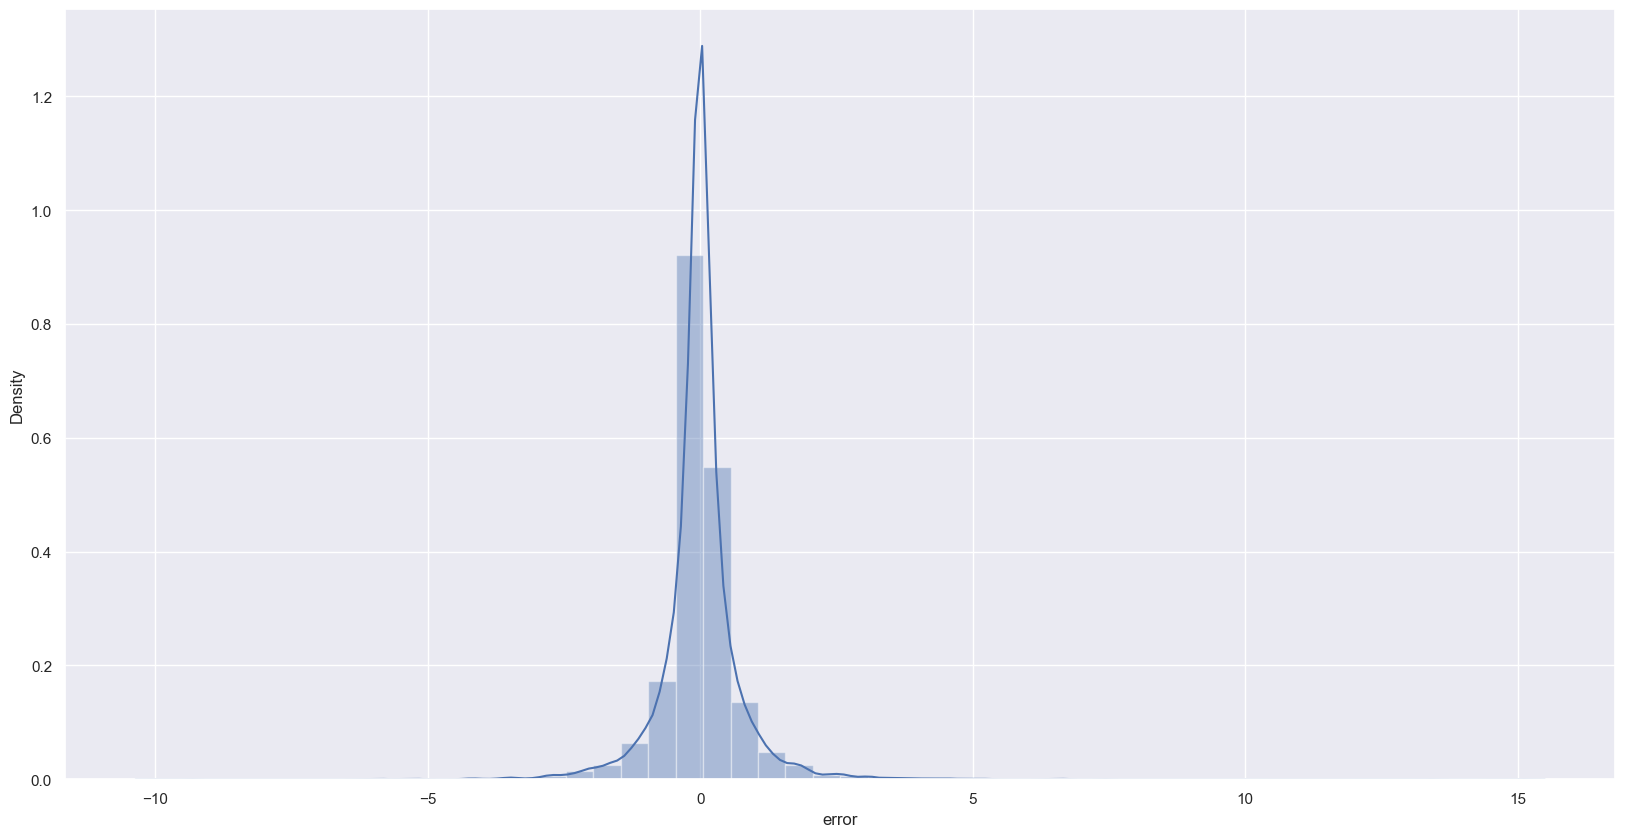

In [59]:
sns.distplot(df4_test['error']);

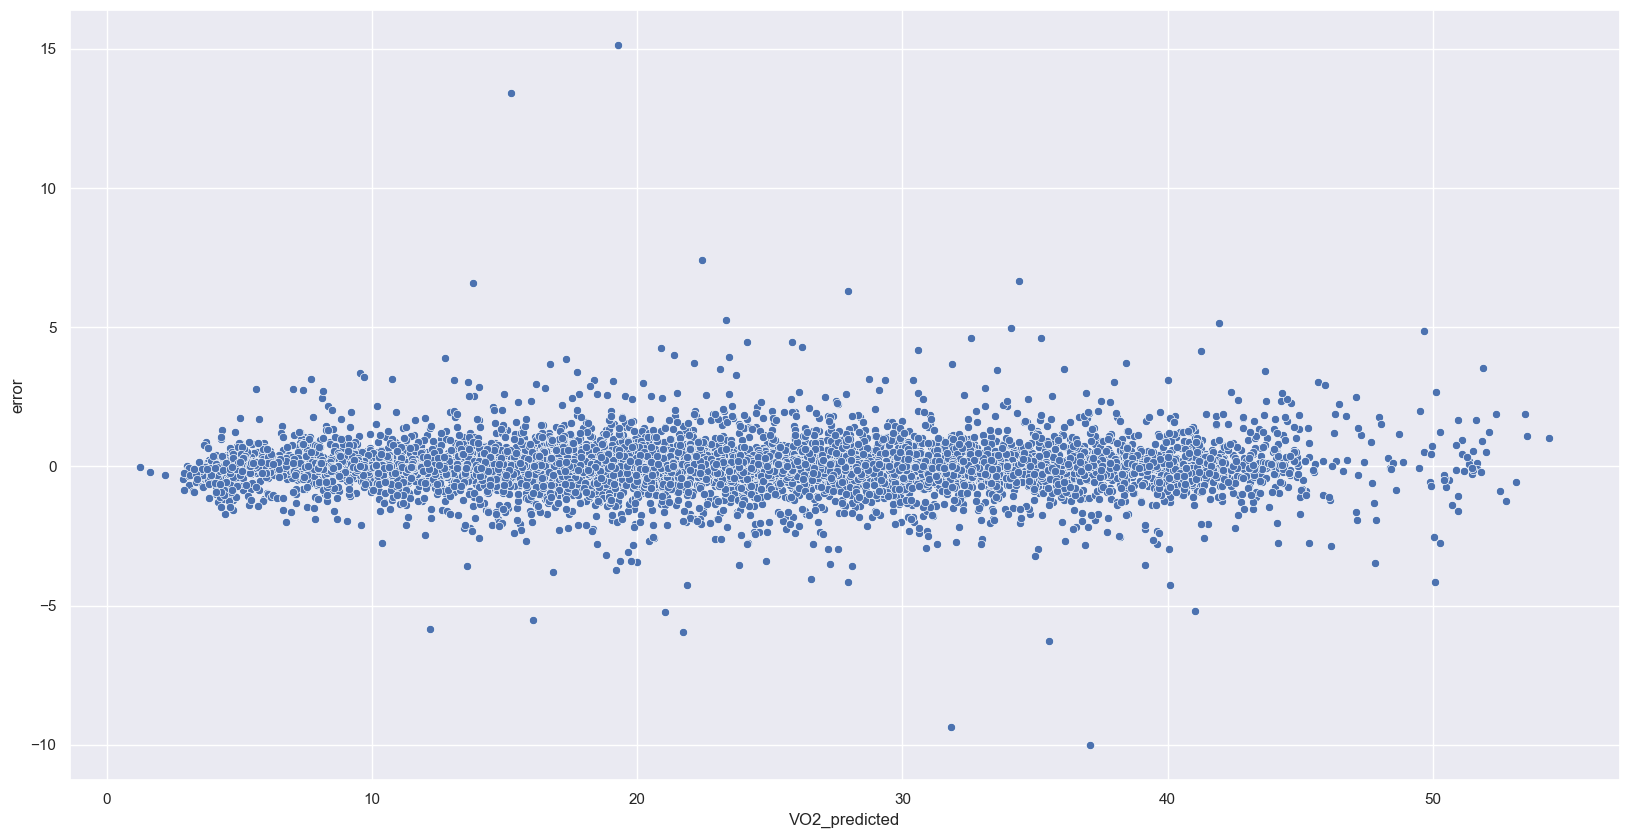

In [60]:
sns.scatterplot(x=df4_test['VO2_predicted'], y=df4_test['error']);


In [61]:
df4_test.sort_values(by='error', ascending=True).head(10)

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2,VO2_predicted,error
47071,17.0000,213.0560,0.3440,0.5636,0.1516,0.0450,106.4614,217.0000,132.0000,30.9117,18.8034,174.4186,12.0000,39.9000,156.0000,0.0000,0.0000,0.0000,27.0646,37.0724,-10.0078
41215,15.0000,81.4400,0.3760,0.7060,0.1564,0.0718,84.9884,176.0000,93.0000,46.6844,24.6684,159.5745,13.0000,63.5000,172.0000,0.0000,0.0000,0.0000,22.4469,31.8172,-9.3703
41963,15.0000,437.2760,0.3200,0.5530,0.1464,0.0433,108.4960,207.0000,98.0000,18.4000,8.7111,187.5000,13.0000,63.5000,172.0000,0.0000,0.0000,0.0000,29.2435,35.5248,-6.2813
43168,15.0000,852.8000,0.3440,0.4454,0.1467,0.0308,134.7113,240.0000,105.0000,10.3004,4.5064,174.4186,13.0000,63.5000,172.0000,0.0000,0.0000,0.0000,15.7907,21.7310,-5.9403
18094,7.0000,14.7880,0.5360,0.7126,0.0954,0.0518,84.1948,196.0000,97.0000,70.7581,35.0181,111.9403,15.0000,49.8000,165.0000,0.0000,0.0000,0.0000,6.3406,12.1988,-5.8583
37835,13.0000,1319.1720,0.3800,0.4369,0.1026,0.0125,137.3439,201.0000,44.0000,5.8396,1.2783,157.8947,18.0000,83.9000,183.0000,0.0000,0.0000,0.1118,10.5474,16.0577,-5.5103
43172,15.0000,854.2640,0.3440,0.4453,0.1466,0.0308,134.7525,243.0000,105.0000,10.4113,4.4987,174.4186,13.0000,63.5000,172.0000,0.0000,0.0000,0.0000,15.7936,21.0394,-5.2458
33266,12.0000,1003.7240,0.3480,0.4709,0.1136,0.0143,127.4236,215.0000,48.0000,8.5284,1.9040,172.4138,18.0000,86.0000,183.0000,0.0000,0.0000,0.1060,35.8290,41.0369,-5.2079
9841,4.0000,767.3160,0.8360,0.4767,0.0938,0.0422,125.8575,242.0000,105.0000,12.1303,5.2632,71.7703,16.0000,76.5000,180.0000,0.0000,0.0000,0.0000,17.5934,21.8686,-4.2752
33265,12.0000,1003.3760,0.3440,0.4709,0.1136,0.0143,127.4104,215.0000,48.0000,8.5317,1.9048,174.4186,18.0000,86.0000,183.0000,0.0000,0.0000,0.1059,35.8290,40.1038,-4.2748


In [62]:
df4_test.sort_values(by='error', ascending=False).head(10)

,TestID,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2,VO2_predicted,error
21535,8.0000,581.2520,16.7120,0.5055,0.4534,0.4251,118.6894,237.0000,167.0000,15.6850,11.0523,3.5902,15.0000,51.2000,165.0000,0.0000,0.0000,0.0000,34.4335,19.2903,15.1432
45940,16.0000,916.2760,0.4200,0.4485,0.6236,0.8623,133.7765,198.0000,68.0000,8.2124,2.8204,142.8571,16.0000,70.4000,182.0000,0.0000,0.0000,0.0000,28.6422,15.2305,13.4117
23641,9.0000,466.8080,0.3440,0.4567,0.1382,0.0307,131.3657,207.0000,102.0000,13.8369,6.8182,174.4186,14.0000,57.1000,176.0000,0.0000,0.0000,0.0000,29.8754,22.4517,7.4237
17141,6.0000,807.1000,0.3440,0.4943,0.1524,0.0290,121.3806,178.0000,103.0000,8.8690,5.1320,174.4186,17.0000,65.6000,169.0000,0.0000,0.0000,0.0000,41.0255,34.3791,6.6464
15404,6.0000,34.4720,0.5520,0.8116,0.1529,0.0737,73.9252,165.0000,99.0000,61.1111,36.6667,108.6957,17.0000,65.6000,169.0000,0.0000,0.0000,0.0000,20.3976,13.8241,6.5736
36030,13.0000,668.6960,0.4080,0.5211,0.0871,0.0175,115.1316,195.0000,43.0000,11.9120,2.6268,147.0588,18.0000,83.9000,183.0000,0.0000,0.0000,0.0000,34.2505,27.9337,6.3168
39559,14.0000,616.4600,0.3640,0.5085,0.2078,0.2194,117.9864,247.0000,103.0000,16.1543,6.7364,164.8352,13.0000,62.3000,171.0000,0.0000,0.0000,0.0000,28.6110,23.3386,5.2723
17154,6.0000,811.5640,0.3480,0.4933,0.1524,0.0289,121.6195,178.0000,103.0000,8.8119,5.0990,172.4138,17.0000,65.6000,169.0000,0.0000,0.0000,0.0000,47.0934,41.9286,5.1648
10430,4.0000,981.2040,0.3360,0.4508,0.0962,0.0391,133.0828,246.0000,108.0000,9.5201,4.1796,178.5714,16.0000,76.5000,180.0000,0.0000,0.0000,0.0698,39.0480,34.0834,4.9647
37382,13.0000,1156.3640,0.3240,0.4486,0.1039,0.0132,133.7508,195.0000,43.0000,6.5239,1.4386,185.1852,18.0000,83.9000,183.0000,0.0000,0.0000,0.1056,54.5503,49.6849,4.8654


In [63]:
df4_test.groupby('TestID').mean().head(20)

,Time,RR,mean_RR,std_RR,rmssd,HR_mean,NN20,NN50,pNN20,pNN50,FC,Idade,Peso,Altura,VLF,LF,HF,VO2,VO2_predicted,error
TestID,,,,,,,,,,,,,,,,,,,,
1.0000,404.4604,0.4110,0.5105,0.1298,0.0431,122.0352,172.6728,100.2658,24.6009,15.2394,154.7997,15.0000,53.7000,161.0000,0.0000,0.0000,0.0000,17.8547,17.8686,-0.0139
2.0000,313.8491,0.4703,0.6033,0.1948,0.0657,104.6775,205.0287,152.6316,32.6574,24.9745,140.7371,15.0000,56.2000,162.0000,0.0000,0.0000,0.0000,19.8311,19.8716,-0.0404
3.0000,677.4405,0.4657,0.5591,0.1237,0.0360,110.7232,155.1723,85.9226,18.6038,10.8095,135.8399,16.0000,89.9000,191.0000,0.0000,0.0000,0.0293,19.9819,20.0006,-0.0187
4.0000,677.9877,0.4153,0.4994,0.1028,0.0535,122.3769,236.9810,104.9390,20.7767,10.1885,149.8795,16.0000,76.5000,180.0000,0.0000,0.0000,0.0253,21.0164,20.9708,0.0456
5.0000,667.2916,0.4346,0.5266,0.1730,0.1650,117.6050,170.3431,95.8736,18.0506,10.3384,145.0456,17.0000,76.4000,186.0000,0.0000,0.0000,0.0364,23.9192,23.9318,-0.0126
6.0000,504.1134,0.4688,0.5990,0.1592,0.0587,103.9389,175.0768,99.8245,23.3334,13.6297,136.2645,17.0000,65.6000,169.0000,0.0000,0.0000,0.0092,26.7687,26.7414,0.0273
7.0000,356.4212,0.4361,0.5331,0.1257,0.0341,116.4404,195.7721,97.1348,28.3784,14.5632,145.8746,15.0000,49.8000,165.0000,0.0000,0.0000,0.0000,17.6202,17.6418,-0.0216
8.0000,380.9244,0.5067,0.6005,0.2510,0.2239,104.1458,215.1779,155.0361,31.8699,24.2948,137.7762,15.0000,51.2000,165.0000,0.0000,0.0000,0.0000,21.3754,21.3406,0.0347
9.0000,413.8954,0.4110,0.5076,0.1299,0.0382,122.8271,197.3795,97.7951,23.7747,12.6255,153.6214,14.0000,57.1000,176.0000,0.0000,0.0000,0.0124,17.7033,17.6836,0.0196


# 6. Model Optimization

In [115]:
# from optuna import create_study, Trial
# from optuna.samplers import TPESampler                  

# def objective(trial: Trial):

#     n_estimators = trial.suggest_int("n_estimators", 10, 50, step=10)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5, step=1)
#     bootstrap = trial.suggest_categorical("bootstrap", [True, False])
#     criterion = trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])

#     print("Training Random Forest Regressor with hyperparameters: ", n_estimators, min_samples_split, min_samples_leaf, bootstrap, criterion)
    
#     # Instantiate Random Forest Regressor with hyperparameters
#     rf = en.RandomForestRegressor(n_jobs=-1, 
#                                   random_state=42,
#                                   n_estimators=n_estimators,
#                                   min_samples_split=min_samples_split,
#                                   min_samples_leaf=min_samples_leaf,
#                                   bootstrap=bootstrap,
#                                   criterion=criterion).fit(x_train, y_train)

#     yhat_rf = rf.predict(x_test)

#     mae, mape, rmse = ml_metrics(mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))

#     new_row = {'n_estimators': n_estimators, 
#                'min_samples_split': min_samples_split, 
#                'min_samples_leaf': min_samples_leaf, 
#                'bootstrap': bootstrap, 
#                'criterion': criterion, 
#                'mae': mae,
#                'mape': mape,
#                'rmse': rmse}

#     global results_df
    
#     results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

#     print(f"MAE: {mae}, MAPE: {mape}, RMSE: {rmse}")

#     return rmse

# results_df = pd.DataFrame(columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bootstrap', 'criterion', 'rmse'])

# sampler = TPESampler(seed=42)
# study = create_study(direction="minimize", sampler=sampler) 
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_result = study.best_value

# print("Best Hyperparameters:", best_params)
# print("Best Result:", best_result)